In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import xarray as xr
import pickle

import pandas as pd
import numpy as np
import datetime as datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
target = 'potential'

In [3]:
mid = "pot-pca"
path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP_PCA/{mid}_outputs"
#check if dir exists and replace if so
if os.path.exists(path):
#if os.path.exists(f'./home/sachin/Documents/NIPR/Research/Data/ML/MLP/{mid}_outputs'):
    pass
else: 
    os.mkdir(path)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
#path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/pbig5min.dat' #Ubuntu
path_reppu = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/pbig5min.dat' #Server

#read the REPPU data
with open (path_reppu) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

reppu_data = reppu_data.reshape(-1,30, 80)
reppu_data.shape

(45792, 30, 80)

In [6]:
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
    for start, end in zip(mhd_data['start'], mhd_data['end'])])

In [7]:
time_res = 5

if time_res == 1:
    time_step = 1440
else :
    time_step = 288

In [8]:
data_reshaped = reppu_data.reshape(len(expanded_dt), time_step, 30, 80) 

# Define coordinates
time = np.arange(time_step)
lat = np.linspace(50, 90, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1, 360, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*time_res))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({target: (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
        coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add potential and units
#ds['potential'].attrs['units'] = 'kV'
ds['potential'] = ds['potential'] * 1e-3 # Convert to kV
ds

<xarray.Dataset> Size: 440MB
Dimensions:    (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt         (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-07-31T23:55:00
  * lat        (lat) float64 240B 50.0 51.38 52.76 54.14 ... 87.24 88.62 90.0
  * lon        (lon) float64 640B 1.0 5.544 10.09 14.63 ... 350.9 355.5 360.0
Data variables:
    potential  (dt, lat, lon) float32 440MB 0.6909 0.507 ... -22.67 -22.71

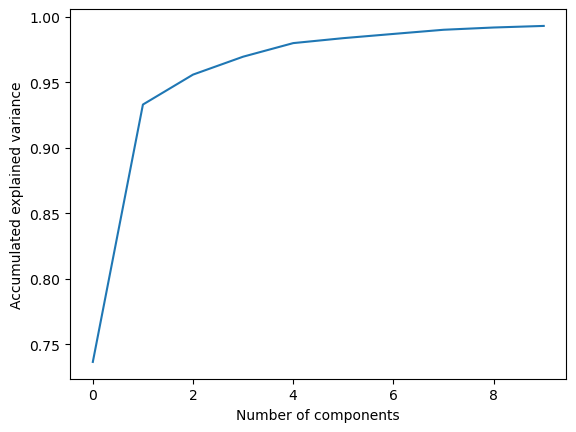

In [9]:
def create_PCA(ds, pca_comps):

    ds = ds.copy()

    ds_arr = ds['potential'].values
    ds_arr = ds_arr.reshape(ds_arr.shape[0], -1)


    pca = PCA(n_components=pca_comps)
    pca.fit(ds_arr)
    reduced = pca.transform(ds_arr) #PCA converted data

    #inverse_transform = pca.inverse_transform(reduced)
    #print(inverse_transform.shape)

    #check for the explained variance. Ideally as close to 1 as possible
    accumulated_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(accumulated_variance)
    plt.xlabel('Number of components')
    plt.ylabel('Accumulated explained variance')

    #new ds with PCA components
    ds_pca = xr.Dataset({'potential': (['dt', 'PC'], reduced)},
                        coords={'dt': ds['dt'], 'PC': np.arange(1, pca_comps+1)})

    return ds_pca, pca, pca_comps

pca_comps = 10
ds, pca, pca_comps = create_PCA(ds, pca_comps)

In [38]:
omni_df = pd.read_csv('omni_mhd_5min.csv')
#omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.ffill().bfill()
omni_df = omni_df.dropna() #drop any remaining NaNs

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='outer')
#reppu_omni_ds['mlt'] = np.mod(reppu_omni_ds['lon'] / 15, 24)

#select date range
reppu_omni_ds = reppu_omni_ds.sortby('dt')
reppu_omni_ds

<xarray.Dataset> Size: 4MB
Dimensions:         (dt: 45792, PC: 10)
Coordinates:
  * dt              (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-08-19T23:55:00
  * PC              (PC) int64 80B 1 2 3 4 5 6 7 8 9 10
Data variables:
    potential       (dt, PC) float32 2MB 407.8 -135.0 -29.71 ... 1.223 -14.07
    BY_GSE          (dt) float64 366kB 4.72 4.35 4.61 4.65 ... -2.49 -2.04 -1.92
    BZ_GSE          (dt) float64 366kB 6.24 6.55 6.56 6.89 ... -4.47 -4.64 -4.5
    flow_speed      (dt) float64 366kB 344.0 344.0 345.0 ... 655.0 653.0 658.0
    proton_density  (dt) float64 366kB 12.11 11.44 12.65 ... 6.22 5.59 5.34
    tilt_angle      (dt) float64 366kB 0.253 0.2497 0.2465 ... 0.1769 0.1735

In [41]:
def lookback(ds, lookback):
    ds_shifted = ds.copy()
    
    for i in range(2, lookback +1, 2):
        ds_shifted[f'BY_GSE(t-{i})'] = ds['BY_GSE'].shift(dt=i)
        ds_shifted[f'BZ_GSE(t-{i})'] = ds['BZ_GSE'].shift(dt=i)
        ds_shifted[f'flow_speed(t-{i})'] = ds['flow_speed'].shift(dt=i)
        ds_shifted[f'proton_density(t-{i})'] = ds['proton_density'].shift(dt=i)
        ds_shifted[f'tilt_angle(t-{i})'] = ds['tilt_angle'].shift(dt=i)

    ds_shifted = ds_shifted.dropna('dt')
    return ds_shifted

lb = 12
reppu_omni_ds_daily_check = lookback(reppu_omni_ds, lb)
#reppu_omni_ds_daily_check = reppu_omni_ds
reppu_omni_ds_daily_check

<xarray.Dataset> Size: 15MB
Dimensions:               (dt: 45780, PC: 10)
Coordinates:
  * dt                    (dt) datetime64[ns] 366kB 2021-05-10T01:00:00 ... 2...
  * PC                    (PC) int64 80B 1 2 3 4 5 6 7 8 9 10
Data variables: (12/36)
    potential             (dt, PC) float32 2MB 254.1 104.2 ... 1.223 -14.07
    BY_GSE                (dt) float64 366kB 5.47 4.43 4.55 ... -2.04 -1.92
    BZ_GSE                (dt) float64 366kB 8.36 8.95 8.45 ... -4.47 -4.64 -4.5
    flow_speed            (dt) float64 366kB 347.0 348.0 348.0 ... 653.0 658.0
    proton_density        (dt) float64 366kB 11.59 11.16 13.98 ... 5.59 5.34
    tilt_angle            (dt) float64 366kB 0.2158 0.213 ... 0.1769 0.1735
    ...                    ...
    tilt_angle(t-10)      (dt) float64 366kB 0.2465 0.2433 ... 0.2117 0.2082
    BY_GSE(t-12)          (dt) float64 366kB 4.72 4.35 4.61 ... -2.71 -2.54
    BZ_GSE(t-12)          (dt) float64 366kB 6.24 6.55 6.56 ... -2.46 -0.13
    flow_speed(t-12)      (dt) float64 366kB 344.0 344.0 345.0 ... 649.0 644.0
    proton_density(t-12)  (dt) float64 366kB 12.11 11.44 12.65 ... 6.58 6.55
    tilt_angle(t-12)      (dt) float64 366kB 0.253 0.2497 ... 0.2188 0.2152

In [12]:

'''
#scale reppu_omni_ds
scaler = MinMaxScaler()
file_path = f'{path}/scaler_{mid}.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(scaler, file)

vars_to_scale = [var for var in reppu_omni_ds.data_vars if var != target]

for var in vars_to_scale:
    values = reppu_omni_ds[var].values.reshape(-1, 1)
    #scaled_values = scaler.fit_transform(values)
    scaled_values = scaler.fit_transform(values).reshape(reppu_omni_ds[var].shape)
    reppu_omni_ds[var] = (reppu_omni_ds[var].dims, scaled_values)
    
'''


"\n#scale reppu_omni_ds\nscaler = MinMaxScaler()\nfile_path = f'{path}/scaler_{mid}.pkl'\n\nwith open(file_path, 'wb') as file:\n    pickle.dump(scaler, file)\n\nvars_to_scale = [var for var in reppu_omni_ds.data_vars if var != target]\n\nfor var in vars_to_scale:\n    values = reppu_omni_ds[var].values.reshape(-1, 1)\n    #scaled_values = scaler.fit_transform(values)\n    scaled_values = scaler.fit_transform(values).reshape(reppu_omni_ds[var].shape)\n    reppu_omni_ds[var] = (reppu_omni_ds[var].dims, scaled_values)\n    \n"

In [42]:
dates_to_remove = pd.date_range(start='2021-05-10 00:00:00', end='2021-05-10 23:55:00', freq='5min')
mask = ~reppu_omni_ds_daily_check['dt'].isin(dates_to_remove)
date1 = reppu_omni_ds_daily_check.where(mask, drop=True)

dates_to_remove2 = pd.date_range(start='2021-10-11 00:00:00', end='2021-10-11 23:55:00', freq='5min')
mask2 = ~date1['dt'].isin(dates_to_remove2)
date2 = date1.where(mask2, drop=True)

dates_to_remove3 = pd.date_range(start='2022-01-30 00:00:00', end='2022-01-30 23:55:00', freq='5min')
mask3 = ~date2['dt'].isin(dates_to_remove3)
reppu_omni_ds = date2.where(mask3, drop=True)
reppu_omni_ds

<xarray.Dataset> Size: 15MB
Dimensions:               (dt: 44928, PC: 10)
Coordinates:
  * dt                    (dt) datetime64[ns] 359kB 2021-05-11 ... 2022-08-19...
  * PC                    (PC) int64 80B 1 2 3 4 5 6 7 8 9 10
Data variables: (12/36)
    potential             (dt, PC) float32 2MB 288.5 -78.05 ... 1.223 -14.07
    BY_GSE                (dt) float64 359kB 4.2 4.22 4.19 ... -2.49 -2.04 -1.92
    BZ_GSE                (dt) float64 359kB -0.59 -0.7 -0.92 ... -4.64 -4.5
    flow_speed            (dt) float64 359kB 340.0 343.0 344.0 ... 653.0 658.0
    proton_density        (dt) float64 359kB 8.97 8.45 8.55 ... 6.22 5.59 5.34
    tilt_angle            (dt) float64 359kB 0.2575 0.2542 ... 0.1769 0.1735
    ...                    ...
    tilt_angle(t-10)      (dt) float64 359kB 0.2915 0.288 ... 0.2117 0.2082
    BY_GSE(t-12)          (dt) float64 359kB 0.96 1.54 2.22 ... -2.71 -2.54
    BZ_GSE(t-12)          (dt) float64 359kB -3.31 -3.29 -2.86 ... -2.46 -0.13
    flow_speed(t-12)      (dt) float64 359kB 349.0 351.0 351.0 ... 649.0 644.0
    proton_density(t-12)  (dt) float64 359kB 7.29 7.77 8.09 ... 6.79 6.58 6.55
    tilt_angle(t-12)      (dt) float64 359kB 0.2985 0.295 ... 0.2188 0.2152

In [43]:
def split_ds(ds, rs=42):
    ds = ds.copy()

    #take random slice of 80% of dt 
    dt = ds['dt'].values

    #split the data into training and testing
    train_dt, temp_dt = train_test_split(dt, test_size=0.2, random_state=rs)
    val_dt, test_dt = train_test_split(temp_dt, test_size=0.5, random_state=rs)

    train_ds = ds.sel(dt=train_dt)
    val_ds = ds.sel(dt=val_dt)
    test_ds = ds.sel(dt=test_dt)

    return train_ds, val_ds, test_ds, test_ds.copy()

train_ds, val_ds, test_ds, test_ds_unscaled = split_ds(reppu_omni_ds)

In [44]:
variables_to_scale = [var for var in train_ds.data_vars if var != 'potential']

#scale reppu_omni_ds
scaler = MinMaxScaler()
file_path = f'{path}/scaler_{mid}.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(scaler, file)

for var in variables_to_scale:
    # Reshape the variable to (-1, 1) to fit the scaler
    X_train_values = train_ds[var].values.reshape(-1,1)
    X_val_values = val_ds[var].values.reshape(-1, 1)
    X_test_values = test_ds[var].values.reshape(-1, 1)

    # Fit and transform on training data, then transform on test data
    scaled_train_values = scaler.fit_transform(X_train_values).reshape(train_ds[var].shape)
    scaled_val_values = scaler.transform(X_val_values).reshape(val_ds[var].shape)
    scaled_test_values = scaler.transform(X_test_values).reshape(test_ds[var].shape)
    
    # Update the xarray dataset with the scaled values
    train_ds[var] = (train_ds[var].dims, scaled_train_values)
    val_ds[var] = (val_ds[var].dims, scaled_val_values)
    test_ds[var] = (test_ds[var].dims, scaled_test_values)

In [45]:
X_train = train_ds.drop_vars('potential').to_array().values.T
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
y_train = train_ds['potential'].values
y_train = y_train.reshape(-1, pca_comps)

X_val = val_ds.drop_vars('potential').to_array().values.T 
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])
y_val = val_ds['potential'].values
y_val = y_val.reshape(-1, pca_comps)

#save variable names
X_var_names = train_ds.drop_vars('potential').to_array().dims
X_test = test_ds.drop_vars('potential').to_array().values.T
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
y_test = test_ds['potential'].values
y_test = y_test.reshape(-1, pca_comps)


In [46]:
class MonteCarloDropout(nn.Dropout):
    def forward(self, input):
        return nn.functional.dropout(input, self.p, True, self.inplace)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 2056),
            nn.ReLU(),
            #MonteCarloDropout(0.2),
            nn.Linear(2056, 1024),
            nn.ReLU(),
            #MonteCarloDropout(0.2), 
	        nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            MonteCarloDropout(0.2), 
            nn.Linear(128, pca_comps),
        )

    def forward(self, x):
        return self.layers(x)

In [47]:
# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

y_train_tensor = y_train_tensor.squeeze(1)
y_test_tensor = y_test_tensor.squeeze(1)
y_val_tensor = y_val_tensor.squeeze(1)

X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape, X_val_tensor.shape, y_val_tensor.shape

(torch.Size([35942, 35]),
 torch.Size([35942, 10]),
 torch.Size([4493, 35]),
 torch.Size([4493, 10]),
 torch.Size([4493, 35]),
 torch.Size([4493, 10]))

In [48]:
# Create a dataset and a dataloader for train and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle validation data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle test data

In [49]:
#check batch size
for x, y in test_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 35]) torch.Size([128, 10])


In [50]:
#Instantiate the MLP model
input_size = X_train.shape[1]
#print('Input size', input_size)
model = MLP(input_size).to(device)

# Define the optimizer, scheulder and the loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.6)
loss_function = nn.L1Loss()

# Track loss and accuracy over epochs
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Early stopping
best_val_loss = float('inf')
patience = 6
counter = 0

In [51]:
start_time = datetime.datetime.now()

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        #print(batch_y.unsqueeze(1).shape)
        #break

        #forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = loss_function(outputs, batch_y)

        #backward pass
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    scheduler.step()

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            val_outputs = model(val_X)
            val_loss += loss_function(val_outputs, val_y).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Print the epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), f'{path}/model_{mid}.pt') #save the best model
    else:
        counter += 1
        if counter >= patience:
            print("Validation loss did not improve for", patience, "epochs. Stopping training.")
            break

end_time = datetime.datetime.now()
diff = end_time - start_time

best_model = model
best_model.load_state_dict(torch.load(f'{path}/model_{mid}.pt'))

Epoch [1/100], Train Loss: 57.8859, Val Loss: 46.1006
Epoch [2/100], Train Loss: 44.8774, Val Loss: 43.4221
Epoch [3/100], Train Loss: 43.3839, Val Loss: 43.7482
Epoch [4/100], Train Loss: 43.0252, Val Loss: 43.0849
Epoch [5/100], Train Loss: 42.6968, Val Loss: 41.8897
Epoch [6/100], Train Loss: 42.1827, Val Loss: 42.2943
Epoch [7/100], Train Loss: 41.9509, Val Loss: 41.4049
Epoch [8/100], Train Loss: 41.6189, Val Loss: 42.3290
Epoch [9/100], Train Loss: 41.4232, Val Loss: 41.3032
Epoch [10/100], Train Loss: 41.2157, Val Loss: 41.6396
Epoch [11/100], Train Loss: 40.4636, Val Loss: 40.6203
Epoch [12/100], Train Loss: 40.3193, Val Loss: 40.4930
Epoch [13/100], Train Loss: 40.1913, Val Loss: 40.4363
Epoch [14/100], Train Loss: 40.1283, Val Loss: 39.9527
Epoch [15/100], Train Loss: 39.8745, Val Loss: 40.1842
Epoch [16/100], Train Loss: 39.7663, Val Loss: 39.9447
Epoch [17/100], Train Loss: 39.5859, Val Loss: 40.1438
Epoch [18/100], Train Loss: 39.5053, Val Loss: 39.4855
Epoch [19/100], Tra

<All keys matched successfully>

In [52]:
#test the model
best_model.eval()
test_loss = 0.0
predictions = []

with torch.no_grad():
    for test_X, test_y in test_loader:
        test_X, test_y = test_X.to(device), test_y.to(device)
        test_outputs = best_model(test_X)
        test_loss += loss_function(test_outputs, test_y).item()
        predictions.append(test_outputs) 

# Convert the predictions to a numpy array
predictions = torch.cat(predictions).cpu()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 37.9826


In [53]:
#y_pred = predictions.cpu()
y_pred = np.asarray(predictions).flatten()
y_test = np.asarray(y_test).flatten()

rmse = np.sqrt(np.mean((y_pred - y_test)**2))
mae = np.mean(np.abs(y_pred - y_test))
R = np.corrcoef(y_pred, y_test)[0, 1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / np.sum((o - np.mean(o))**2))
    return skill          

print(f"RMSE (PCA): {rmse:.1f}")
print(f"MAE (PCA): {mae:.1f}")
print(f"R (PCA): {R:.2f}/1")
print(f"Skill (PCA): {skill(y_pred, y_test):.2f}/1")

RMSE (PCA): 77.2
MAE (PCA): 37.9
R (PCA): 0.87/1
Skill (PCA): 0.75/1


In [54]:
def convert_to_original_scale(ds, predictions):
    ds = ds.copy()

    #vars_to_scale = [var for var in ds.data_vars if var != target]
    #for var in vars_to_scale:
    #    values = ds[var].values.reshape(-1, 1)
    #    original_scale_values = scaler.inverse_transform(values).reshape(ds[var].shape)
        #print(values.shape)
        #break
    #    ds[var] = (ds[var].dims, original_scale_values)

    potential = ds['potential'].values
    potential = potential.reshape(-1, pca_comps)
    potential_original = pca.inverse_transform(potential)
    potential_original = potential_original.reshape(-1, 30, 80)

    ds['predicted_potential'] = (['dt', 'PC'], predictions)
    potential_pred = ds['predicted_potential'].values
    potential_pred = potential_pred.reshape(-1, pca_comps)
    potential_pred_original = pca.inverse_transform(potential_pred)
    potential_pred_original = potential_pred_original.reshape(-1, 30, 80)

    lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
    lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°
    new_ds = xr.Dataset({'potential': (['dt', 'lat', 'lon'], potential_original),
                        'pred_pot': (['dt', 'lat', 'lon'], potential_pred_original)},
                        coords={'dt': ds['dt'], 'lat': lat, 'lon': lon})
    
    new_ds['BY_GSE'] = ds['BY_GSE']
    new_ds['BZ_GSE'] = ds['BZ_GSE']
    new_ds['flow_speed'] = ds['flow_speed']
    new_ds['proton_density'] = ds['proton_density']
    new_ds['tilt_angle'] = ds['tilt_angle']
    
    new_ds.to_netcdf(f'{path}/y_ds_{mid}.nc')
       
    return new_ds


new_ds = convert_to_original_scale(test_ds_unscaled, predictions)
new_ds

<xarray.Dataset> Size: 86MB
Dimensions:         (dt: 4493, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 36kB 2022-02-03T16:25:00 ... 2021-12-...
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables:
    potential       (dt, lat, lon) float32 43MB 1.279 0.663 ... 8.311 8.309
    pred_pot        (dt, lat, lon) float32 43MB 1.508 0.9132 ... 6.268 6.252
    BY_GSE          (dt) float64 36kB 3.61 2.61 -4.9 -3.47 ... 4.57 2.43 -1.57
    BZ_GSE          (dt) float64 36kB -1.29 0.61 -2.99 ... 0.52 -1.45 -0.32
    flow_speed      (dt) float64 36kB 545.0 349.0 580.0 ... 317.0 365.0 488.0
    proton_density  (dt) float64 36kB 3.68 5.18 5.21 5.62 ... 7.53 12.52 4.23
    tilt_angle      (dt) float64 36kB -0.1259 -0.4942 0.3499 ... -0.3964 -0.5569

<Axes: >

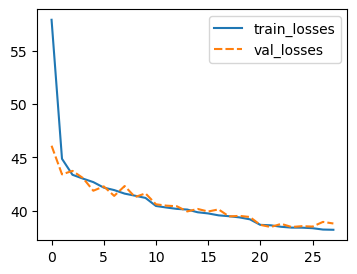

In [55]:
loss_df = pd.DataFrame({'train_losses':train_losses, 'val_losses':val_losses})
loss_df.to_csv(f'{path}/train-val-curves_{mid}.csv')
plt.figure(figsize=(4, 3))
sns.lineplot(data=loss_df)

In [56]:
potential = new_ds['potential'].values
potential = potential.reshape(-1, pca_comps)

pred_pot = new_ds['pred_pot'].values
pred_pot = pred_pot.reshape(-1, pca_comps)

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / 
            np.sum((o - np.mean(o))**2))

    return skill             

RMSE = np.sqrt(np.mean((potential - pred_pot)**2))
NRMSE = RMSE / (np.max(potential) - np.min(potential))
MAE = np.mean(np.abs(potential - pred_pot))
PE = skill(potential, pred_pot)
R = np.corrcoef(potential.flatten(), pred_pot.flatten())[0, 1]

print(f'RMSE: {RMSE:.2f} kV')
print(f'NRMSE: {NRMSE:.2f}')
#print(f'MAE: {MAE:.1f} kV')
print(f'R: {R:.2f}/1')
print(f'PE: {PE:.2f}/1')

RMSE: 4.98 kV
NRMSE: 0.03
R: 0.90/1
PE: 0.75/1


In [28]:
#save run info
with open(f'{path}/run-info_{mid}.txt', 'w') as f:
    f.write(f'unit,value\n')
    f.write(f'Epochs,{epoch+1}\n')
    f.write(f'Total Time,{diff}\n')
    f.write(f'Train Loss,{(train_loss):.2f}\n')
    f.write(f'Val Loss,{(val_loss):.2f}\n')
    f.write(f'Test Loss,{test_loss:.2f}\n')
    f.write(f'RMSE,{rmse:.2f}\n')
    f.write(f'MAE,{mae:.2f}\n')
    f.write(f'R,{R:.2f}\n')
    #f.write(f'MC Test Loss,{(mc_loss.item()):.2f}\n')

In [61]:
def daily_prediction(ds):
    ds = ds.copy()
    df = ds.to_dataframe().reset_index()

    #df=df[['dt',target,'BY_GSE','BZ_GSE','flow_speed','proton_density','tilt_angle']]
    df_2 = df.copy()
    df_2 = df_2.drop(columns=['dt', 'PC', target])

    col_names = df_2.columns
    norm_arr = scaler.fit_transform(df_2)
    df_2 = pd.DataFrame(norm_arr, columns=col_names)
    df_2 = df_2.to_numpy()
    df_2 = torch.tensor(df_2, dtype=torch.float32).to(device)
    
    def batch_pred(df):
        batch_size = 1000
        n = len(df)
        predictions = []

        for i in range(0, n, batch_size):
            batch = df[i:i+batch_size]
            batch_pred = best_model(batch).detach().cpu().numpy()
            predictions.extend(batch_pred)

        return predictions
    
    def single_pred(df):
        predictions = best_model(df).detach().cpu().numpy()
        return predictions
    
    predictions = batch_pred(df_2)
    #predictions = single_pred(df_2)

    df['predicted_potential'] = predictions
    df = df.explode('predicted_potential')
    df['PC'] = np.tile(np.arange(1, pca_comps+1), len(df)//pca_comps)
    
    return df, df_2

date1 = reppu_omni_ds_daily_check.sel(dt=slice('2021-05-10 00:00:00', '2021-05-10 23:55:00'))
date2 = reppu_omni_ds_daily_check.sel(dt=slice('2021-10-11 00:00:00', '2021-10-11 23:55:00'))
date3 = reppu_omni_ds_daily_check.sel(dt=slice('2022-01-30 00:00:00', '2022-01-30 23:55:00'))
#daily_prediction(date1)

df_raw, df_proc = daily_prediction(date3)
df_raw

,dt,PC,potential,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,BY_GSE(t-2),BZ_GSE(t-2),...,BZ_GSE(t-10),flow_speed(t-10),proton_density(t-10),tilt_angle(t-10),BY_GSE(t-12),BZ_GSE(t-12),flow_speed(t-12),proton_density(t-12),tilt_angle(t-12),predicted_potential
0,2022-01-30 00:00:00,1,480.496216,4.29,1.31,551.0,1.50,-0.344534,-9.94,-1.39,...,2.03,305.0,11.46,-0.332594,-10.48,0.50,303.0,13.51,-0.325574,-1870.354858
0,2022-01-30 00:00:00,2,480.496216,4.29,1.31,551.0,1.50,-0.344534,-9.94,-1.39,...,2.03,305.0,11.46,-0.332594,-10.48,0.50,303.0,13.51,-0.325574,1050.47168
0,2022-01-30 00:00:00,3,480.496216,4.29,1.31,551.0,1.50,-0.344534,-9.94,-1.39,...,2.03,305.0,11.46,-0.332594,-10.48,0.50,303.0,13.51,-0.325574,-14.912813
0,2022-01-30 00:00:00,4,480.496216,4.29,1.31,551.0,1.50,-0.344534,-9.94,-1.39,...,2.03,305.0,11.46,-0.332594,-10.48,0.50,303.0,13.51,-0.325574,-264.849945
0,2022-01-30 00:00:00,5,480.496216,4.29,1.31,551.0,1.50,-0.344534,-9.94,-1.39,...,2.03,305.0,11.46,-0.332594,-10.48,0.50,303.0,13.51,-0.325574,106.976601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,2022-01-30 23:55:00,6,-8.305313,-3.96,-3.17,477.0,1.25,-0.336227,-2.13,-4.17,...,-2.30,460.0,1.86,-0.301246,-3.86,-2.95,465.0,1.58,-0.294239,18.093048
2879,2022-01-30 23:55:00,7,-8.305313,-3.96,-3.17,477.0,1.25,-0.336227,-2.13,-4.17,...,-2.30,460.0,1.86,-0.301246,-3.86,-2.95,465.0,1.58,-0.294239,34.853584
2879,2022-01-30 23:55:00,8,-8.305313,-3.96,-3.17,477.0,1.25,-0.336227,-2.13,-4.17,...,-2.30,460.0,1.86,-0.301246,-3.86,-2.95,465.0,1.58,-0.294239,7.853728
2879,2022-01-30 23:55:00,9,-8.305313,-3.96,-3.17,477.0,1.25,-0.336227,-2.13,-4.17,...,-2.30,460.0,1.86,-0.301246,-3.86,-2.95,465.0,1.58,-0.294239,-32.332382


In [62]:
def inverse_PCA(df):
    df = df.copy()

    df = df.groupby(['dt', 'PC']).mean()
    #df = df.set_index(['dt','PC'])
    #df = 
    ds = df.to_xarray()
    potential = ds['predicted_potential'].values
    potential = potential.reshape(-1, pca_comps)
    potential_original = pca.inverse_transform(potential)
    potential_original = potential_original.reshape(-1, 30, 80)

    lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
    lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°
    new_ds = xr.Dataset({'potential_pred_mlp_pca': (['dt', 'lat', 'lon'], potential_original)},
                        coords={'dt': ds['dt'], 'lat': lat, 'lon': lon})
    
    new_ds['BY_GSE'] = ds['BY_GSE']
    new_ds['BZ_GSE'] = ds['BZ_GSE']
    new_ds['flow_speed'] = ds['flow_speed']
    new_ds['proton_density'] = ds['proton_density']
    new_ds['tilt_angle'] = ds['tilt_angle']

    new_ds.to_netcdf(f'{path}/date3_ds_{mid}_id5.nc')

    #hist of predicted potential
    #plt.figure(figsize=(8, 4))
    #sns.histplot(potential_original.flatten(), bins=100)

    return new_ds

inverse_PCA(df_raw)

<xarray.Dataset> Size: 6MB
Dimensions:                 (dt: 288, lat: 30, lon: 80, PC: 10)
Coordinates:
  * dt                      (dt) datetime64[ns] 2kB 2022-01-30 ... 2022-01-30...
  * lat                     (lat) float64 240B 53.1 54.36 55.62 ... 88.44 89.7
  * lon                     (lon) float64 640B 1.6 6.106 10.61 ... 353.1 357.6
  * PC                      (PC) int64 80B 1 2 3 4 5 6 7 8 9 10
Data variables:
    potential_pred_mlp_pca  (dt, lat, lon) object 6MB 4.794500057004399 ... -...
    BY_GSE                  (dt, PC) float64 23kB 4.29 4.29 4.29 ... -3.96 -3.96
    BZ_GSE                  (dt, PC) float64 23kB 1.31 1.31 1.31 ... -3.17 -3.17
    flow_speed              (dt, PC) float64 23kB 551.0 551.0 ... 477.0 477.0
    proton_density          (dt, PC) float64 23kB 1.5 1.5 1.5 ... 1.25 1.25 1.25
    tilt_angle              (dt, PC) float64 23kB -0.3445 -0.3445 ... -0.3362